In [58]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fiona
import os

### Apportion the population with each OA

In [40]:
# File paths
oa_population_shapefile = './data/output_area_population.shp'
oa_age_bands_csv = './data/oa_age_bands.csv'

# Load shapefile and CSV
print("Loading shapefile and CSVs...")
oa_gdf = gpd.read_file(oa_population_shapefile)
oa_age_bands_df = pd.read_csv(oa_age_bands_csv)

# Ensure population CSV column names are consistent
oa_age_bands_df.columns = ['OA21CD', 'Population']

# Merge the output area population data with the OA GeoDataFrame
print("Merging output area population data with OA GeoDataFrame...")
oa_gdf = oa_gdf.merge(oa_age_bands_df, on='OA21CD', how='left')

# Rename the columns to make sure we are clear
oa_gdf.rename(columns={'Population_x': 'Park_Population', 'Population_y': 'OA_Population'}, inplace=True)

# Print columns of oa_gdf to verify
print("Columns in oa_gdf:")
print(oa_gdf.columns)

# Print the first few rows of oa_gdf to inspect the data
print("First few rows of oa_gdf:")
print(oa_gdf.head())

# Calculate the population per address
print("Calculating population per address...")
oa_gdf['pop_per_address'] = oa_gdf['OA_Population'] / oa_gdf['total_addr']

# Calculate the population inside and outside the national parks
oa_gdf['pop_inside'] = oa_gdf['pop_per_address'] * oa_gdf['address_in']
oa_gdf['pop_outside'] = oa_gdf['pop_per_address'] * oa_gdf['address_ou']

# Print the first few rows of the updated oa_gdf to inspect the calculations
print("First few rows of the updated oa_gdf:")
print(oa_gdf[['OA21CD', 'OA_Population', 'total_addr', 'address_in', 'address_ou', 'pop_per_address', 'pop_inside', 'pop_outside']].head())

# Save the updated GeoDataFrame to a new shapefile
output_shapefile = './data/output_area_population_apportioned.shp'
print(f"Saving the updated GeoDataFrame to {output_shapefile}...")
oa_gdf.to_file(output_shapefile, driver='ESRI Shapefile')

Loading shapefile and CSVs...
Merging output area population data with OA GeoDataFrame...
Columns in oa_gdf:
Index(['OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT',
       'LONG', 'GlobalID', 'index_righ', 'CODE', 'NAME', 'MEASURE',
       'DESIG_DATE', 'HOTLINK', 'STATUS', 'National_P', 'Park_Population',
       'address_in', 'total_addr', 'address_ou', 'geometry', 'OA_Population'],
      dtype='object')
First few rows of oa_gdf:
      OA21CD   LSOA21CD        LSOA21NM LSOA21NMW   BNG_E   BNG_N      LAT  \
0  E00027390  E01005409     Oldham 020D      None  402127  403557  53.5287   
1  E00027395  E01005410     Oldham 006A      None  401338  408961  53.5773   
2  E00027396  E01005410     Oldham 006A      None  402683  407583  53.5649   
3  E00027401  E01005410     Oldham 006A      None  401412  406686  53.5568   
4  E00029923  E01005908  Stockport 017D      None  398819  387648  53.3857   

      LONG                              GlobalID  index_righ  ...  DESIG_

C:\Users\alexad\AppData\Local\Temp\ipykernel_25760\2913384284.py:46: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  oa_gdf.to_file(output_shapefile, driver='ESRI Shapefile')
c:\Users\alexad\AppData\Local\anaconda3\envs\np-os\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Field DESIG_DATE create as date field, though DateTime requested.
  ogr_write(
c:\Users\alexad\AppData\Local\anaconda3\envs\np-os\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Park_Population' to 'Park_Popul'
  ogr_write(
c:\Users\alexad\AppData\Local\anaconda3\envs\np-os\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'OA_Population' to 'OA_Populat'
  ogr_write(
c:\Users\alexad\AppData\Local\anaconda3\envs\np-os\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'pop_per_address' to 'pop_per_ad'
  ogr_write(
c:\Users\alexad\AppData\Local\anac

### Optomize the threshold

Loading shapefile and national park population data...
Unique names in oa_gdf['National_P']: ['PEAK DISTRICT' 'NORTH YORK MOORS' 'SOUTH DOWNS' 'LAKE DISTRICT'
 'NORTHUMBERLAND' 'YORKSHIRE DALES' 'EXMOOR' 'DARTMOOR' 'NEW FOREST'
 'THE BROADS']
Unique names in national_park_pop_df['National park']: ['Bannau Brycheiniog' 'Dartmoor' 'Eryri' 'Exmoor' 'Lake District'
 'New Forest' 'North York Moors' 'Northumberland' 'Peak District'
 'Pembrokeshire Coast' 'South Downs' 'The Broads' 'Yorkshire Dales']
Optimal Threshold: 0.0430
Minimum Error: 1228.4929835596834
Final Population Calculation:
National_P
Dartmoor             34095.765318
Exmoor               10159.412101
Lake District        38896.020814
New Forest           33989.089008
North York Moors     22651.116997
Northumberland        1844.295810
Peak District        35880.024430
South Downs         113544.333273
The Broads            6499.068338
Yorkshire Dales      22953.815851
Name: pop_in_threshold, dtype: float64
Final Result:
      N

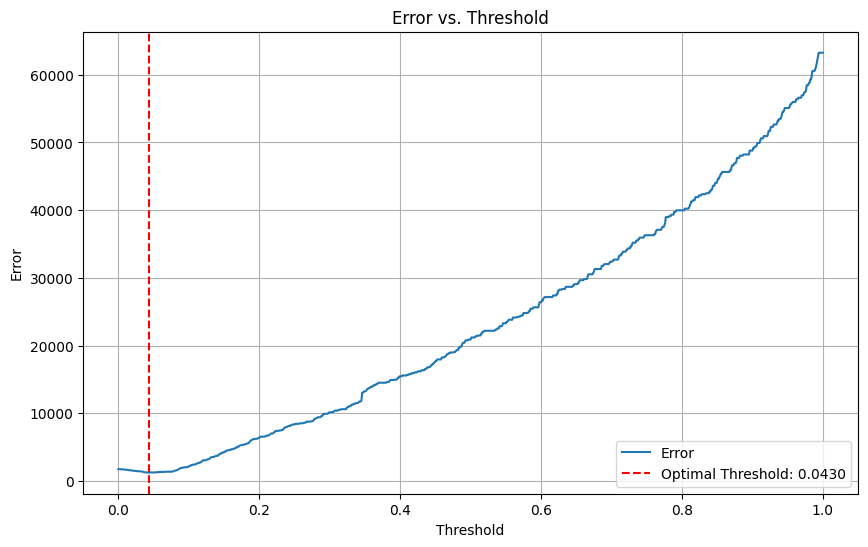

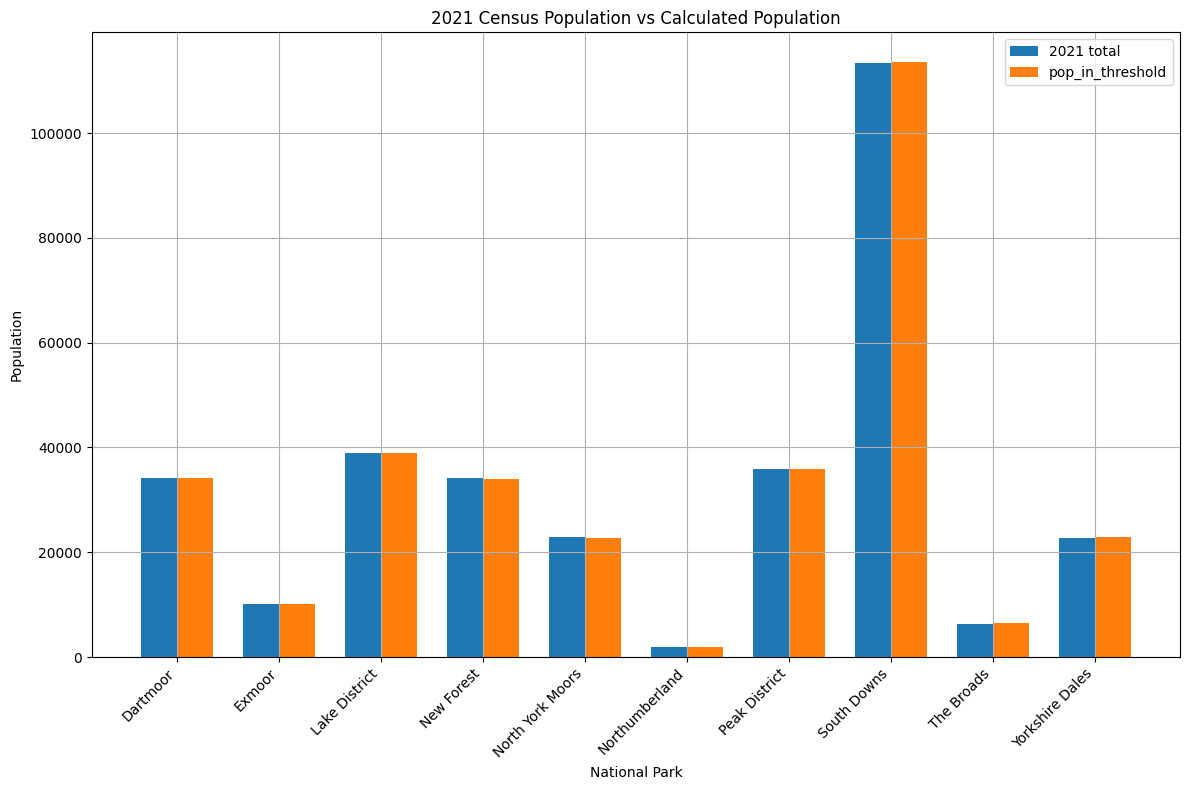

In [59]:
# Load the necessary data
oa_population_shapefile = './data/output_area_population_apportioned.shp'
national_park_pop_csv = './data/national_park_pop.csv'

# Load shapefile and CSV
print("Loading shapefile and national park population data...")
oa_gdf = gpd.read_file(oa_population_shapefile)
national_park_pop_df = pd.read_csv(national_park_pop_csv)

# Ensure '2021 total' is numeric
national_park_pop_df['2021 total'] = national_park_pop_df['2021 total'].str.replace(',', '').astype(float)

# Print unique names in both dataframes
print("Unique names in oa_gdf['National_P']:", oa_gdf['National_P'].unique())
print("Unique names in national_park_pop_df['National park']:", national_park_pop_df['National park'].unique())

# Function to align park names
def align_park_names(oa_gdf, national_park_pop_df):
    # Create a dictionary to map incorrect names to correct ones if needed
    name_mapping = {
        'PEAK DISTRICT': 'Peak District',
        'NORTH YORK MOORS': 'North York Moors',
        'SOUTH DOWNS': 'South Downs',
        'LAKE DISTRICT': 'Lake District',
        'NORTHUMBERLAND': 'Northumberland',
        'YORKSHIRE DALES': 'Yorkshire Dales',
        'EXMOOR': 'Exmoor',
        'DARTMOOR': 'Dartmoor',
        'NEW FOREST': 'New Forest',
        'THE BROADS': 'The Broads'
    }
    
    # Apply the mapping
    oa_gdf['National_P'] = oa_gdf['National_P'].replace(name_mapping)
    return oa_gdf

# Align the names
oa_gdf = align_park_names(oa_gdf, national_park_pop_df)

# Function to calculate population based on a threshold
def calculate_population(threshold):
    oa_gdf['pop_in_threshold'] = oa_gdf.apply(
        lambda row: row['pop_inside'] if (row['address_in'] / row['total_addr']) >= threshold else 0, axis=1
    )
    return oa_gdf.groupby('National_P')['pop_in_threshold'].sum()

# Function to calculate the error between calculated and census population
def calculate_error(threshold):
    calculated_pop = calculate_population(threshold)
    merged_df = pd.merge(national_park_pop_df, calculated_pop, left_on='National park', right_on='National_P', how='inner')
    merged_df['difference'] = merged_df['2021 total'] - merged_df['pop_in_threshold']
    return abs(merged_df['difference']).sum()

# Iterate through a range of thresholds to find the optimal one
thresholds = [i / 1000.0 for i in range(0, 1001)]  # From 0.0 to 1.0 in steps of 0.001
errors = []
for threshold in thresholds:
    error = calculate_error(threshold)
    errors.append((threshold, error))

# Find the threshold with the minimum error
optimal_threshold, min_error = min(errors, key=lambda x: x[1])
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Minimum Error: {min_error}")

# Calculate the population using the optimal threshold
final_population = calculate_population(optimal_threshold)
print("Final Population Calculation:")
print(final_population)

# Merge the final calculated population with the census data
final_result = pd.merge(national_park_pop_df, final_population, left_on='National park', right_on='National_P', how='inner')
final_result['difference'] = final_result['2021 total'] - final_result['pop_in_threshold']

# Save the final result to a CSV file
final_result.to_csv('final_population_comparison.csv', index=False)

# Print the final result
print("Final Result:")
print(final_result[['National park', '2021 total', 'pop_in_threshold', 'difference']])

# Plot the errors
threshold_values = [x[0] for x in errors]
error_values = [x[1] for x in errors]

plt.figure(figsize=(10, 6))
plt.plot(threshold_values, error_values, label='Error')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Error')
plt.title('Error vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Plot the final population comparison side by side
bar_width = 0.35
index = np.arange(len(final_result['National park']))

plt.figure(figsize=(12, 8))
plt.bar(index, final_result['2021 total'], bar_width, label='2021 total')
plt.bar(index + bar_width, final_result['pop_in_threshold'], bar_width, label='pop_in_threshold')

plt.xlabel('National Park')
plt.ylabel('Population')
plt.title('2021 Census Population vs Calculated Population')
plt.xticks(index + bar_width / 2, final_result['National park'], rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()